In [12]:
from libs.corp_df import *
from tqdm.auto import tqdm
from libs.get_docs import getDocs
from libs.dim_red import *
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering

In [5]:
# retrieve documents
print('Retrieving Documents...')
cdir = 'corpora/articles_stage2/*.json'
docs = getDocs(cdir, verbose=False)

Retrieving Documents...


  0%|          | 0/524 [00:00<?, ?it/s]

In [6]:
roots_raw = []
print('getting raw roots...')
for doc in tqdm(docs):
    for pg in doc:
        for sent in pg:
            for tok in sent:
                for lem in tok:
                    if lem.pos_tag in ['VB', 'BN', 'BNT']:
                        if lem.shoresh is not None:
                            roots_raw.append(lem.shoresh)

getting raw roots...


  0%|          | 0/524 [00:00<?, ?it/s]

In [7]:
# filter by minimum # occurrences
print('filtering...')
valid_roots = set([i for i in tqdm(roots_raw) if roots_raw.count(i) > 19])
print(len(valid_roots))

filtering...


  0%|          | 0/26165 [00:00<?, ?it/s]

308


In [13]:
# select random roots
NUM_ROOTS = 5

# randomly chosen roots
slct_roots = random.sample(valid_roots, NUM_ROOTS)
print(slct_roots)

['תלה', 'שקע', 'צפה', 'כשל', 'עזר']


In [14]:
# get all embeddings with roots in them
lemmas, roots, embeddings, binyanim = [], [], [], []
for doc in tqdm(docs):
    for pg in doc:
        for sent in pg:
            for tok in sent:
                for lem in tok:
                    if lem.shoresh in slct_roots:
                        lemmas.append(lem.lemma)
                        roots.append(lem.shoresh)
                        embeddings.append(tok.getEmbedding(layers=[-4, -3, -2, -1]))
                        binyanim.append(lem.binyan)
                        
print('Total records found: {}'.format(len(lemmas)))
print()
print('Distributions of Roots:')

for root in slct_roots:
    percentage = roots.count(root) / len(roots)
    print('{}: {}'.format(root, np.round(percentage,3)))

  0%|          | 0/524 [00:00<?, ?it/s]

Total records found: 196

Distributions of Roots:
תלה: 0.143
שקע: 0.168
צפה: 0.388
כשל: 0.168
עזר: 0.133


In [15]:
# dimensionality reduction
x, y = tsne([e.numpy() for e in embeddings], verbose=True)

df = pd.DataFrame({'lemma': lemmas, 'root': roots, 
                   'embedding': embeddings, 'binyan': binyanim, 
                   'x': x, 'y': y})

n_clusters = len(set(roots)) + 1
kmeans = KMeans(n_clusters=n_clusters)
agglo = AgglomerativeClustering(n_clusters=n_clusters)

for name, method in [('kmeans', kmeans), ('agglomerative', agglo)]:
    df[name] = method.fit_predict([i.numpy() for i in df['embedding']])

TIME ELAPSED: 0.66


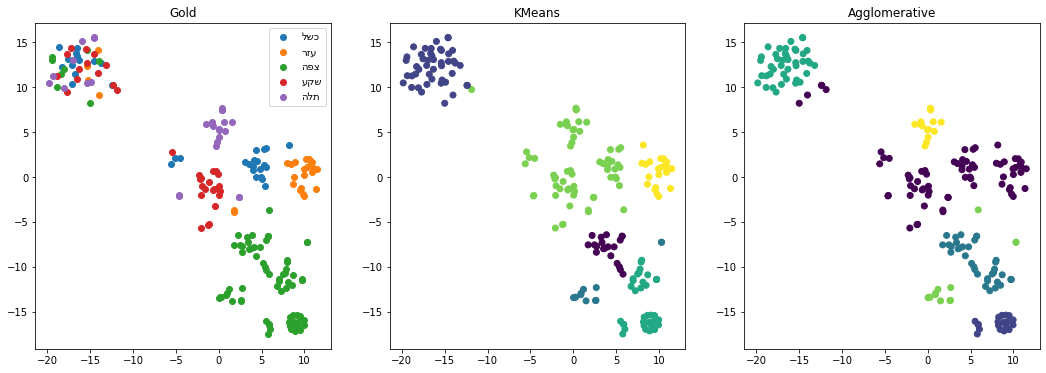

In [16]:
fig, (gold, kmeans_plot, agglo_plot) = plt.subplots(1, 3, figsize=(18, 6))

# plot gold labels
for cat, dff in df.groupby('root'):
    gold.scatter(dff['x'], dff['y'], label=cat[::-1])

# plot clusters
kmeans_plot.scatter(df['x'], df['y'], c=df['kmeans'], cmap='viridis')
agglo_plot.scatter(df['x'], df['y'], c=df['agglomerative'], cmap='viridis')

gold.legend()
gold.set_title('Gold')
kmeans_plot.set_title('KMeans')
agglo_plot.set_title('Agglomerative')
plt.show()